In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

In [2]:
dataset = pd.read_csv('dataset/long_term_TCS.NS.csv')
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume,timeframe
0,2002-08-12,38.724998,40.000000,38.724998,39.700001,27.998854,212976.0,1d
1,2002-08-13,39.750000,40.387501,38.875000,39.162498,27.619785,153576.0,1d
2,2002-08-14,39.250000,39.250000,35.724998,36.462502,25.715569,822776.0,1d
3,2002-08-15,36.462502,36.462502,36.462502,36.462502,25.715569,0.0,1d
4,2002-08-16,36.275002,38.000000,35.750000,36.375000,25.653860,811856.0,1d


In [9]:
from sklearn.preprocessing import MinMaxScaler

price = dataset[['Close']]
scaler = MinMaxScaler(feature_range=(-1,1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))
price.head()

/tmp/ipykernel_27317/2653096151.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))


,Close
0,-0.997946
1,-0.998207
2,-0.999520
3,-0.999520
4,-0.999562


In [10]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy()
    data = []

    for index in range(len(data_raw) - lookback):
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data)
    
    test_set_size = int(np.round(0.2 * data.shape[0]))
    train_set_size = data.shape[0] - test_set_size

    x_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, :]

    x_test = data[train_set_size:, :-1]
    y_test = data[train_set_size:, -1, :]

    return [x_train, y_train, x_test, y_test]

lookback = 20
x_train, y_train, x_test, y_test = split_data(price, lookback)

In [11]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_text = torch.from_numpy(x_test).type(torch.Tensor)

y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [12]:
input_dim = 1
hidden_dim = 32
num_layer = 2
output_dim = 1
num_epoch = 100

In [34]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layer, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layer = num_layer

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layer, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layer, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layer, x.size(0), self.hidden_dim).requires_grad_()

        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [35]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layer=num_layer)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [36]:
import time

hist = np.zeros(num_epoch)
start_time = time.time()
lstm = []

for t in range(num_epoch):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train)
    print('Epoch:', t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time() - start_time
print(f"Training time: {training_time}")

Epoch: 0 MSE:  0.47905245423316956
Epoch: 1 MSE:  0.34873253107070923
Epoch: 2 MSE:  0.2551478147506714
Epoch: 3 MSE:  0.2754489779472351
Epoch: 4 MSE:  0.217691570520401
Epoch: 5 MSE:  0.1800876259803772
Epoch: 6 MSE:  0.16005946695804596
Epoch: 7 MSE:  0.12292749434709549
Epoch: 8 MSE:  0.06985468417406082
Epoch: 9 MSE:  0.08609787374734879
Epoch: 10 MSE:  0.03785623237490654
Epoch: 11 MSE:  0.03567373752593994
Epoch: 12 MSE:  0.0495755672454834
Epoch: 13 MSE:  0.03490658849477768
Epoch: 14 MSE:  0.021855829283595085
Epoch: 15 MSE:  0.022656584158539772
Epoch: 16 MSE:  0.02084708958864212
Epoch: 17 MSE:  0.013498027808964252
Epoch: 18 MSE:  0.01113247312605381
Epoch: 19 MSE:  0.014797046780586243
Epoch: 20 MSE:  0.01868618093430996
Epoch: 21 MSE:  0.01877843774855137
Epoch: 22 MSE:  0.015296597965061665
Epoch: 23 MSE:  0.011384827084839344
Epoch: 24 MSE:  0.010290606878697872
Epoch: 25 MSE:  0.011714480817317963
Epoch: 26 MSE:  0.01167443860322237
Epoch: 27 MSE:  0.008534058928489685

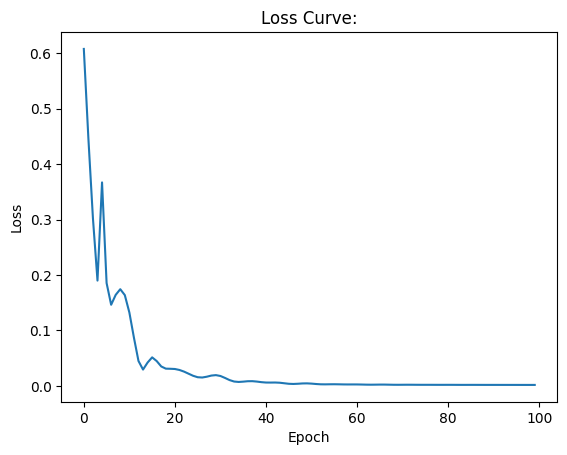

In [23]:
plt.plot(hist)
plt.title("Loss Curve:")

plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [39]:
with torch.no_grad():
    test_pred = model(x_test)


TypeError: 'int' object is not callable

In [ ]:
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

In [ ]:
train_rmse = np.sqrt(((y_train - y_train_pred) ** 2).mean())
test_rmse = np.sqrt(((y_test - y_test_pred) ** 2).mean())

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

In [ ]:
plt.plot(y_test, label="True Price")
plt.plot(y_test_pred, label="Predicted Price")
plt.title("TCS Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()